In [1]:
% load_ext autoreload
% autoreload 2


In [2]:
import glob
import os
import pandas as pd
from collections import defaultdict
import datetime
import src.mex_helper as mex
import folium
from src.utils.map_vis import time_slider_choropleth, geojson_per_row

# average over weekday and weekend

In [3]:
call_direction = 'out+in'

In [4]:
%%time
aver = mex.stat_tw_dow_aver_hr_uniq_user(call_direction)

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle
CPU times: user 1.42 s, sys: 40 ms, total: 1.46 s
Wall time: 1.44 s


In [5]:
tw_avg_wd = pd.DataFrame(aver['wd']).T
tw_avg_wk = pd.DataFrame(aver['wk']).T

## difference between use out+in and only out is small

In [6]:
aver_out = mex.stat_tw_dow_aver_hr_uniq_user('out')

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out.pickle


In [7]:
div = tw_avg_wd/pd.DataFrame(aver_out['wd']).T

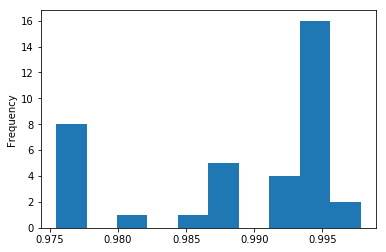

In [8]:
%matplotlib inline
series = pd.Series(div.values.flatten())
series[series<1].plot(kind='hist')

# distribute tower stats to grids

In [40]:
# rkind = 'cities'
# rname='city'
# rname='urban'
# rkind = 'urban_areas_16'
# rkind = 'mpa_all_uba'

rname='metropolitan'
# rkind = 'metropolitans_16'
rkind='metropolitans_all'

gside=1000
loc_buffer = 500

hotspot_type = 'average'
hotspot_type = 'loubar'

# wrong
# t2loc=mex.tower2loc_by_pop()
# loc2grid = mex.loc2grid_by_area(rkind, gside, loc_buffer=500)

t2l2g = mex.tower2loc2grid(loc_buffer, rkind, gside)

In [41]:
print(
    'number of towers in cities has no call at all during weekday and weekend',
    len(set(t2l2g.tower) - set(tw_avg_wd.index)),
    len(set(t2l2g.tower) - set(tw_avg_wk.index))
)

number of towers in cities has no call at all during weekday and weekend 323 347


In [42]:
t2g = t2l2g.groupby(['grid','tower']).weight.sum().reset_index()

In [43]:
def grid_avgerage(tw_avg, t2g):
    # there are grids without any call throughout the observation period
#     print('grid_average')
    g_avg = t2g.merge(tw_avg, left_on='tower', right_index=True, how='left')
    
    for h in range(24):
        h = str(h)
        g_avg[h] = g_avg[h] * g_avg['weight']

    g_avg = g_avg[['grid','tower']+[str(h) for h in range(24)]].groupby('grid').sum()  # fillna=0 by default

    return g_avg

In [44]:
g_avg_wd = grid_avgerage(tw_avg_wd, t2g)
g_avg_wk = grid_avgerage(tw_avg_wk, t2g)

# visualize by hour each city

In [45]:
from src.utils import loubar_thres
import numpy as np
def keep_hotspot(avg):
    for h in avg:
        arr = avg[h]
        if hotspot_type=='loubar':
            _, arr_thres = loubar_thres(arr, is_sorted=False)
        elif hotspot_type=='average':
            arr_thres = np.mean(arr)
        else:
            raise ValueError('hotspot type', hotspot_type,'not implemented')
        avg[h][avg[h] <= arr_thres] = 0
        # print(h, loubar, arr_thres)
    return avg


In [46]:
mex_grids = mex.grids(rkind, gside)

reading existing grids


In [47]:
fake_dates = [f"1971-01-{i:02}" for i in range(1,25)]

In [48]:
print('rkind:', rkind)
mex_regions = mex.regions(rkind)

rkind: metropolitans_all


## all grids

In [34]:
%%time
print(rkind, rname)
for dow, g_avg in [('wd', g_avg_wd), ('wk',g_avg_wk)]:
    print('day of week:', dow)
    for c in mex_regions.index[[0]]:
#         if 'Tecomán' not in c:
#             continue
        lon,lat = mex_regions.loc[c].geometry.centroid.coords[0]
        gc = mex_grids[mex_grids[rname]==c]
        gc_avg = g_avg.reindex(set(gc.grid)&set(g_avg.index)).sort_index()
        values = gc_avg.T.to_dict('list')
        some_map = folium.Map(location=[lat,lon], zoom_start=10)
        time_slider_choropleth(gc, values, fake_dates, color_per_day=True).add_to(some_map)
        some_map.save(f'maps-v0908/MexGridChoropleth-{call_direction}-{rkind}/{c}_{dow}-Pop.html')

metropolitans_all metropolitan
day of week: wd
day of week: wk
CPU times: user 1min 19s, sys: 76 ms, total: 1min 19s
Wall time: 1min 20s


## keep hotspot only

In [34]:
%%time
for dow, g_avg in [('wd', g_avg_wd), ('wk',g_avg_wk)]:
    print('day of week:', dow)
    for c in mex_regions.index:
        lon,lat = mex_regions.loc[c].geometry.centroid.coords[0]
        gc = mex_grids[mex_grids[rname]==c]
        gc_avg = g_avg.loc[gc.grid].copy()
        keep_hotspot(gc_avg)
        values = gc_avg.T.to_dict('list')
        some_map = folium.Map(location=[lat,lon], zoom_start=10)
        time_slider_choropleth(gc, values, fake_dates, color_per_day=True).add_to(some_map)
#         break
        some_map.save(f'maps-v0908/MexGridChoroplethHotSpot-{call_direction}-{rkind}/{c}_{dow}-Pop.html')
#     break

day of week: wd


/home/Jiahui/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


ValueError: cannot convert float NaN to integer

## hotspot persistency

In [49]:
from branca.colormap import linear
cmap = linear.Reds_09.scale(0,24)

In [50]:
%%time
for dow, g_avg in [('wd', g_avg_wd), ('wk',g_avg_wk)]:
    print('day of week:', dow)
    
    some_map = folium.Map(location=[mex.CLAT,mex.CLON], zoom_start=8)
    
    for c in mex_regions.index:
        cgeom=mex_regions.loc[c].geometry
        lon,lat = cgeom.centroid.coords[0]
        gc = mex_grids[mex_grids[rname]==c].copy()
        gc_avg = g_avg.loc[gc.grid].copy()
        # there could be grids with no call
        gc_avg.fillna(0,inplace=True)
        keep_hotspot(gc_avg)
        gc['persistency'] = (gc_avg!=0).sum(axis=1)
        gc = gc[gc.persistency!=0]
        gc = gc.append({'grid':-1, 'geometry':cgeom, 'persistency':0},ignore_index=True).sort_values('grid')
        gjson = gc[['grid','persistency','geometry']].to_json()
        folium.GeoJson(
            gjson,
            name=c,
            style_function=lambda feature: {
                'fillColor': cmap(feature['properties']['persistency']),
                'color': 'black',
                'weight': 1,
                'dashArray': '5, 5',
                'fillOpacity': 0.8,
            }
        ).add_to(some_map)
#         break
    
    cmap.caption = 'hotspot persistency (hours)'
    cmap.add_to(some_map)
    folium.LayerControl(collapsed=False).add_to(some_map)
    some_map.save(f'maps-v0916/MexHotSpot-{hotspot_type}-Persistency_{dow}-{call_direction}-{rkind}-{gside}-pop.html')
#     break


day of week: wd


/home/Jiahui/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


day of week: wk
CPU times: user 22.7 s, sys: 36 ms, total: 22.8 s
Wall time: 22.7 s
